# Visualise Images

This notebook demonstrates how to display an image along with some contours, scalar overlays and bounding boxes.

## Import Modules

The following cell imports the modules needed for this example. This 'ImageVisualiser' class does most of the heavy lifting regarding visualisation. It has a number of helpful functions, and makes adding additional information to an image (relatively) pain-free.

In [1]:
# Check if platipy is installed, if not install it.
try:
    import platipy
except:
    !pip install platipy
    import platipy

# The ImageVisualiser clas
from platipy.imaging import ImageVisualiser

# Function to grab some test data
from platipy.imaging.tests.data import get_lung_nifti

# Usual suspects
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt

# Some utilities we use for generating interesting data
from platipy.imaging.registration.utils import convert_mask_to_reg_structure, apply_transform
from platipy.imaging.registration.deformable import fast_symmetric_forces_demons_registration
from platipy.imaging.generation.dvf import generate_field_asymmetric_extend
from platipy.imaging.label.utils import get_com
from platipy.imaging.utils.crop import label_to_roi

## Download Test Data

Some Lung test data from LCTSC is fetched here for use in this example notebook.

In [2]:
input_directory = get_lung_nifti()

## Read in the data

- ct_image: the x-ray computed tomography scan (3D)
- contours: a dictionary of binary masks

In [3]:
pat_directory = input_directory.joinpath("LCTSC-Test-S1-101")

# Read in the CT image
ct_filename = next(pat_directory.glob("**/IMAGES/*.nii.gz"))
ct_image = sitk.ReadImage(ct_filename.as_posix())

# Read in the RTStruct contours as binary masks
contour_filename_list = list(pat_directory.glob("**/STRUCTURES/*.nii.gz"))

contours = {}
for contour_filename in contour_filename_list:
    _name = contour_filename.name.split(".nii.gz")[0].split("RTSTRUCT_")[-1]
    
    contours[_name] = sitk.ReadImage(contour_filename.as_posix())

## Display Image with Contours

Here we define 'cut', the location of orthogonal slices

- cut: (
        transaxial slice location *or* first axis,
        coronal slice location *or* second axis,
        saggital slice location *or* third axis,
        )
    

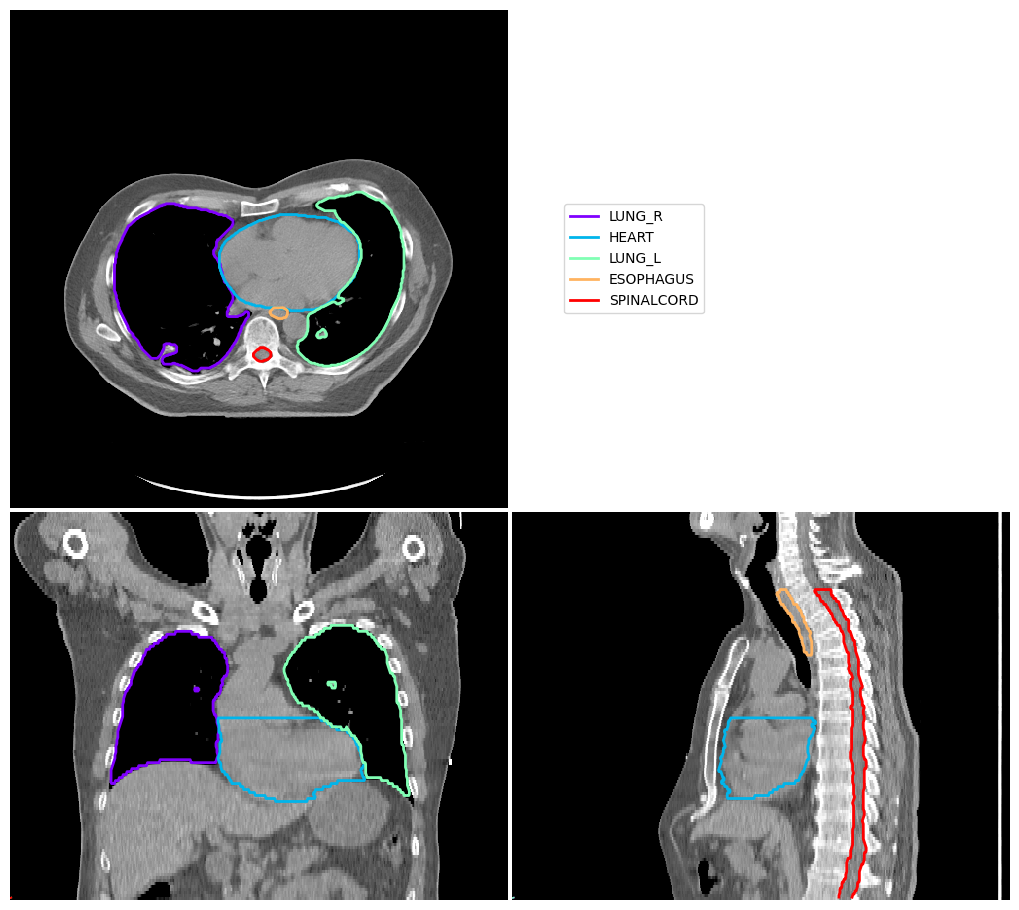

In [4]:
image_visualiser = ImageVisualiser(ct_image, cut=(50,256,256))
image_visualiser.add_contour(contours)
fig = image_visualiser.show()

## Display Image without Contours

Here we change the intensity windowing, for example to better visualise lung tissue

- window: (
        minimum intensity,
        range in intensity
        )
        
It is also possible to use difference colormaps to display the image.

We can also change the field of view, for example using to the lung volumes.

We also don't need to set 'cut', in which case the middle of the image volume is displayed.

    

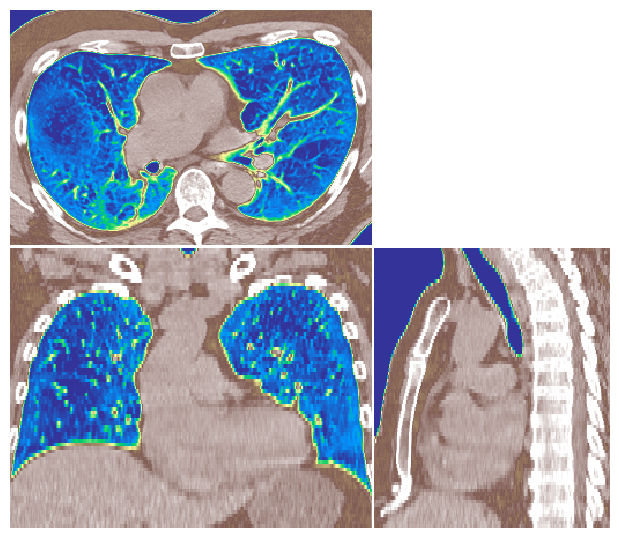

In [5]:
image_visualiser = ImageVisualiser(ct_image, window=(-900, 1100), colormap=plt.cm.get_cmap("terrain"), figure_size_in=6)

image_visualiser.set_limits_from_label(contours["LUNG_L"] + contours["LUNG_R"])

fig = image_visualiser.show()

## Display Image using Projection

Another way to visualise a 3D image volume is using a projection. Here we demonstrate a mean intensity projection.

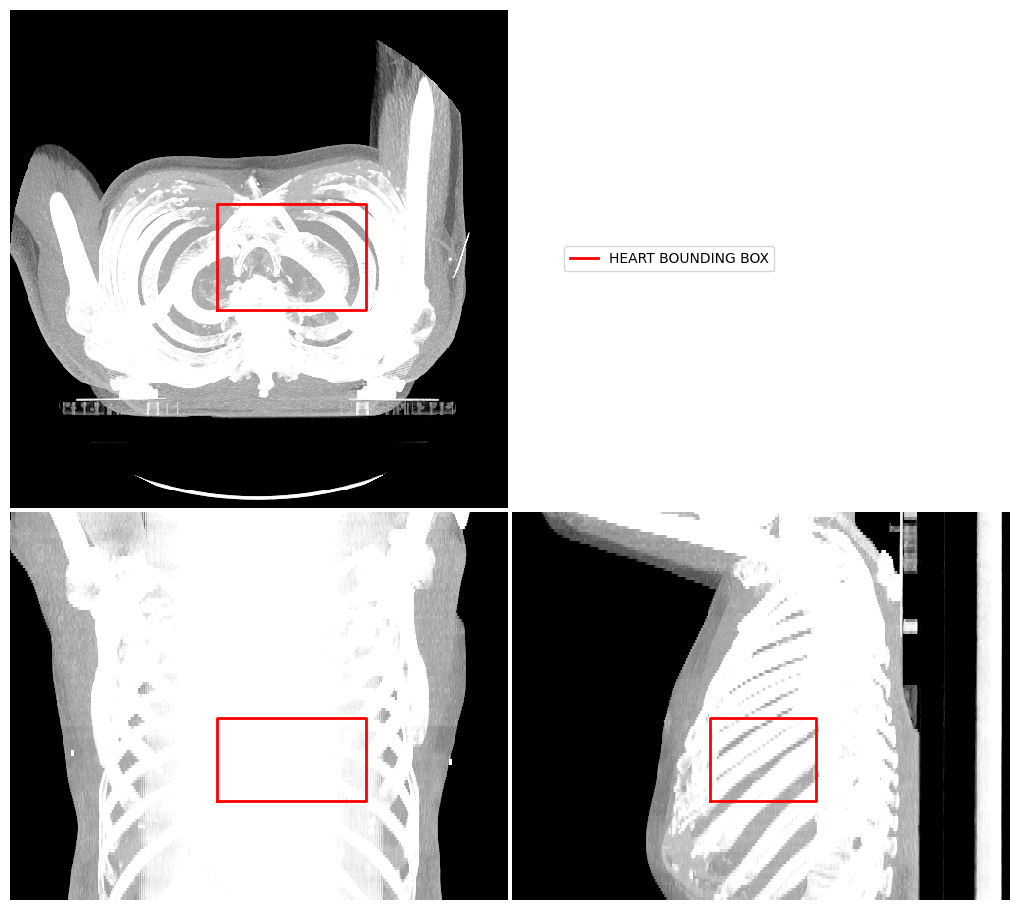

In [6]:
image_visualiser = ImageVisualiser(ct_image, projection=True)

image_visualiser.add_bounding_box(label_to_roi(contours["HEART"], return_as_list=True), name="HEART BOUNDING BOX")

fig = image_visualiser.show()

## Display Scalar Field on Image

There are also tools to visualise scalar fields. Here is an example using a normalised distance map, which we compute for the heart volume.

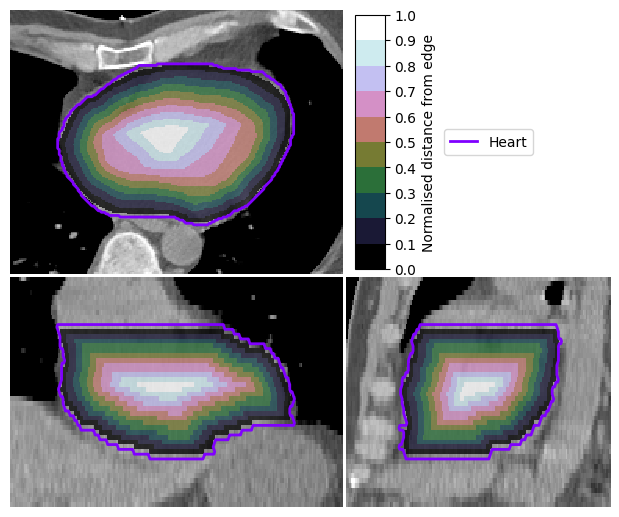

In [7]:
ndm_heart = convert_mask_to_reg_structure(contours["HEART"], expansion=1)

image_visualiser = ImageVisualiser(ct_image, cut=get_com(contours["HEART"]), figure_size_in=6)

image_visualiser.add_scalar_overlay(ndm_heart, name="Normalised distance from edge", discrete_levels=10)
image_visualiser.add_contour(contours["HEART"], name="Heart", show_legend=True)

image_visualiser.set_limits_from_label(contours["HEART"], expansion=30)

fig = image_visualiser.show()

## Overlay Vector Fields on Image

We can also display vector fields. Here we compute one, simulated by expanding the heart volume by 5mm (for this simulation, we also use some nice tools in platipy).

In [8]:
contours["HEART_EXPAND"], tfm_expansion, dvf_expansion = generate_field_asymmetric_extend(contours["HEART"])

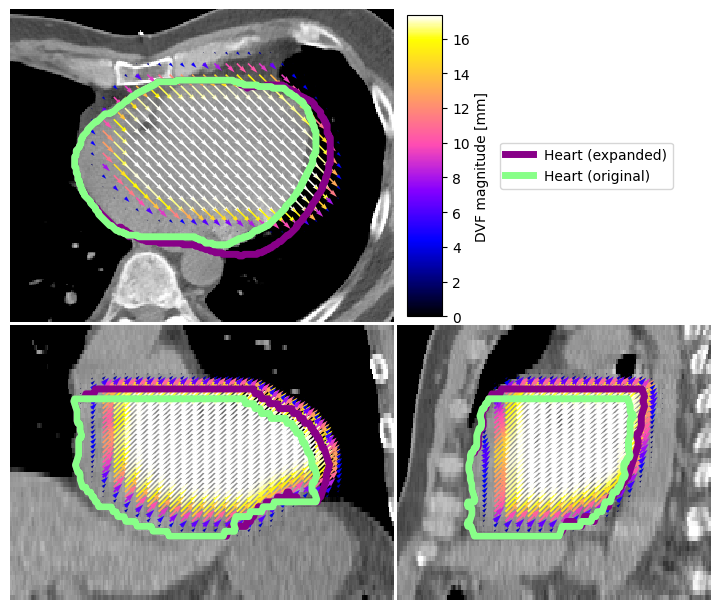

In [9]:
image_visualiser = ImageVisualiser(ct_image, cut=get_com(contours["HEART"]), figure_size_in=7)

image_visualiser.add_vector_overlay(
    dvf_expansion,
    name="DVF magnitude [mm]",
    colormap=plt.cm.get_cmap("gnuplot2"),
    alpha=0.75,
    arrow_scale=1,
    arrow_width=1,
    subsample=(2,6,6),
    color_function='magnitude',
    show_colorbar=True
)

image_visualiser.add_contour(contours["HEART_EXPAND"], name = "Heart (expanded)", color="#880088", linewidth=5)
image_visualiser.add_contour(contours["HEART"], name = "Heart (original)", color="#88FF88", linewidth=5)

image_visualiser.set_limits_from_label(contours["HEART_EXPAND"], expansion=40)

fig = image_visualiser.show()

## Compare two Images

We can also visualise comparisons between images. This can be helpful for checking registration performance visually.

In this example, we deform the ct_image using the transformation above (heart expansion).


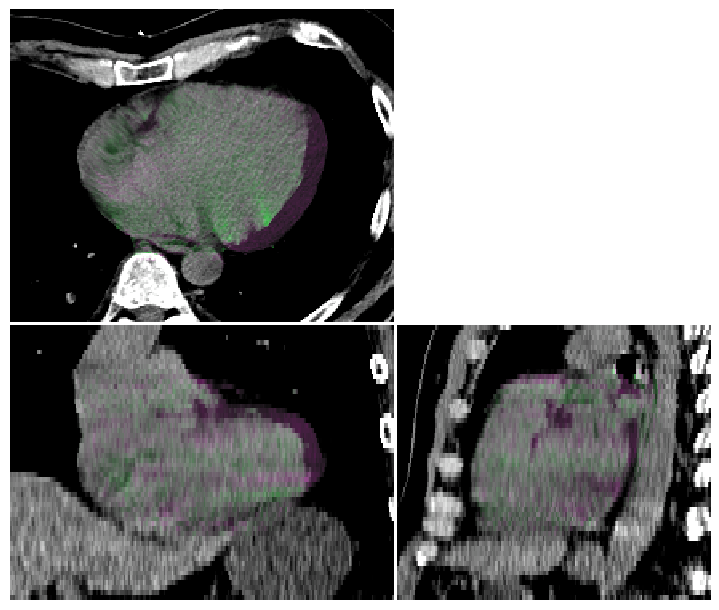

In [10]:
ct_image_deformed = apply_transform(
    input_image=ct_image,
    reference_image=None,
    transform=tfm_expansion,
    default_value=-1000,
    interpolator=sitk.sitkBSpline,
)

image_visualiser = ImageVisualiser(ct_image, cut=get_com(contours["HEART"]), figure_size_in=7, window=(-40, 200))

image_visualiser.add_comparison_overlay(ct_image_deformed)

image_visualiser.set_limits_from_label(contours["HEART_EXPAND"], expansion=40)

fig = image_visualiser.show()

## Combine Visualisations

For experienced matplotlib users, it is also possible to customise the figure after it has been created. We can add test, more axes, etc. as usual...

Text(0.5, 0, 'Results')

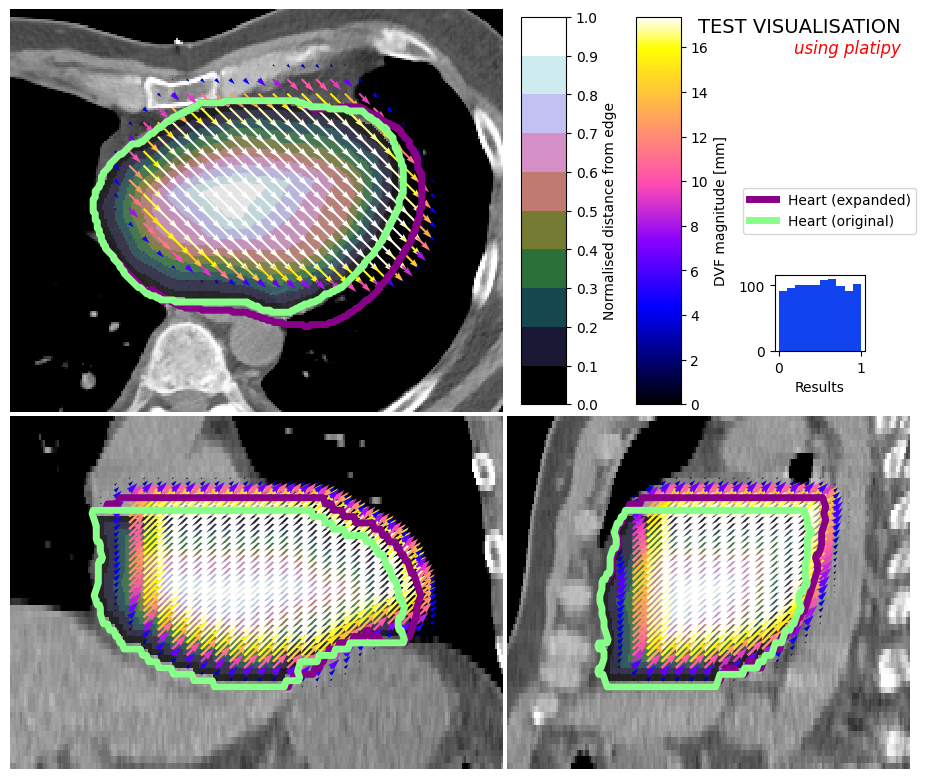

In [11]:
image_visualiser = ImageVisualiser(ct_image, cut=get_com(contours["HEART"]), figure_size_in=9)

image_visualiser.add_scalar_overlay(ndm_heart, name="Normalised distance from edge", discrete_levels=10)

image_visualiser.add_contour(contours["HEART_EXPAND"], name = "Heart (expanded)", color="#880088", linewidth=5)
image_visualiser.add_contour(contours["HEART"], name = "Heart (original)", color="#88FF88", linewidth=5)

image_visualiser.add_vector_overlay(
    dvf_expansion,
    name="DVF magnitude [mm]",
    colormap=plt.cm.get_cmap("gnuplot2"),
    alpha=0.5,
    arrow_scale=1,
    arrow_width=1,
    subsample=(2,6,6),
    color_function='magnitude',
    show_colorbar=True
)

image_visualiser.set_limits_from_label(contours["HEART_EXPAND"], expansion=40)

fig = image_visualiser.show()

# Here we can add stuff to the figure

fig.text(0.99, 0.99, "TEST VISUALISATION", va="top", ha="right", fontsize=14)
fig.text(0.99, 0.96, "using platipy", va="top", ha="right", fontsize=12, style="italic", c="red");

test_axis = fig.add_axes( (0.85, 0.55, 0.1, 0.1) )
test_axis.hist(np.random.random(1000), histtype="stepfilled", fc = "#1144EE", ec=None)
test_axis.set_xlabel("Results")

# Optionally, save the figure
# fig.savefig("./output.jpeg", dpi=500)